In [1]:
import sys
print(sys.executable)

/opt/tljh/user/bin/python


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import TensorDataset, DataLoader
import math
import torch.nn.functional as F

from ano_nn_analysis import *

import warnings
warnings.filterwarnings(action='ignore')

## data load

In [3]:
data = pd.read_pickle('krx_data_5Y.pkl')
data.head(10)

,today,종가,대비,시가,고가,저가,내재변동성,익일기준가,거래량,거래대금,미결제약정,이름,분류,만기월,행사가,만기일,잔존만기,rate,kvix,주식가격
0,2019-01-02,0.91,-0.38,0.92,0.92,0.91,15.7,0.91,3,1,38,코스피200 C 201906 302.5,1,201906,302.5,2019-06-13,0.464286,1.964,19.74,258.23
1,2019-01-02,0.01,0,0.01,0.01,0.01,19.1,0.01,1,0,1090,코스피200 C 201902 312.5,1,201902,312.5,2019-02-14,0.126984,1.964,19.74,258.23
2,2019-01-02,0.02,0,0.03,0.03,0.02,17.7,0.02,7,0,549,코스피200 C 201903 322.5,1,201903,322.5,2019-03-14,0.206349,1.964,19.74,258.23
3,2019-01-02,0.68,-0.15,0.6,0.68,0.6,15.8,0.68,3,0,3,코스피200 C 201904 292.5,1,201904,292.5,2019-04-11,0.285714,1.964,19.74,258.23
4,2019-01-02,0.02,-0.01,0.03,0.03,0.02,16.3,0.02,924,5,2273,코스피200 C 201902 300.0,1,201902,300.0,2019-02-14,0.126984,1.964,19.74,258.23
5,2019-01-02,7.6,-0.85,7.6,7.6,7.6,17.5,7.60,9,17,4171,코스피200 C 201903 260.0,1,201903,260.0,2019-03-14,0.206349,1.964,19.74,258.23
6,2019-01-02,0.3,-0.28,0.72,0.72,0.28,15.3,0.30,3635,367,3509,코스피200 C 201902 282.5,1,201902,282.5,2019-02-14,0.126984,1.964,19.74,258.23
7,2019-01-02,1.05,-0.38,1.48,1.48,1.05,15.6,1.05,286,84,10239,코스피200 C 201906 300.0,1,201906,300.0,2019-06-13,0.464286,1.964,19.74,258.23
8,2019-01-02,1.93,-0.13,1.99,2.01,1.93,15.7,1.93,4,2,47,코스피200 C 201909 305.0,1,201909,305.0,2019-09-12,0.722222,1.964,19.74,258.23
9,2019-01-02,7.8,0.59,6.93,7.8,6.93,17.8,7.80,1307,2445,14973,코스피200 P 201906 250.0,0,201906,250.0,2019-06-13,0.464286,1.964,19.74,258.23


In [4]:
data['종가'] = pd.to_numeric(data['종가'], errors='coerce')
data['주식가격'] = pd.to_numeric(data['주식가격'], errors='coerce')
data['행사가'] = pd.to_numeric(data['행사가'], errors='coerce')
data['잔존만기'] = pd.to_numeric(data['잔존만기'], errors='coerce')
data['rate'] = pd.to_numeric(data['rate'], errors='coerce')

# simple moneyness 계산
data['simple moneyness'] = data['주식가격'] / data['행사가']

# S - Ke^(-rT) 계산
data['parity'] = data['주식가격'] - (data['행사가'] * np.exp(-(data['rate'] / 100) * data['잔존만기']))

# 풋옵션 가격
data['put_price'] = data.apply(lambda row: row['종가'] - row['parity'] if row['분류'] == 1 else row['종가'], axis=1)

# 콜옵션 가격
data['call_price'] = data.apply(lambda row: row['종가'] + row['parity'] if row['분류'] == 0 else row['종가'], axis=1)

# 풋옵션 가격이 0보다 작은 경우 0으로 설정
data['put_price'] = np.where((data['분류'] == 1) & (data['put_price'] < 0), 0, data['put_price'])

# 최종 종가 설정
data['종가'] = data['put_price']

# 필요한 컬럼만 선택
data = data[['today', '분류', '거래량', '미결제약정', 'simple moneyness', '잔존만기', 'rate', 'kvix', '종가']]

# 인덱스 설정 및 결측값 제거
data.set_index('today', inplace=True)
data.dropna(how='any', inplace=True)

In [5]:
data.describe()

,분류,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가
count,346675.000000,346675.000000,346675.000000,346675.000000,346675.000000,346675.000000,346675.000000,346675.000000
mean,0.432503,3998.091460,4377.711710,1.100580,0.238392,1.753715,19.560488,20.532218
std,0.495424,16321.830999,7701.255742,0.286341,0.203567,1.117591,6.887440,31.532767
min,0.000000,1.000000,0.000000,0.498200,0.023810,0.307000,11.730000,0.000000
25%,0.000000,5.000000,200.000000,0.914382,0.099206,0.686000,15.020000,0.477391
50%,0.000000,42.000000,1176.000000,1.033875,0.170635,1.484000,17.750000,4.650000
75%,1.000000,549.000000,5374.000000,1.219016,0.293651,3.000000,21.970000,30.575005
max,1.000000,480413.000000,159624.000000,3.145714,1.075397,4.019000,69.240000,237.150000


## seed ##

In [6]:
import os
GPU_NUM = 6 # 원하는 GPU 번호 입력
rank = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')

os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_NUM)

dtype = torch.double

# IsoForest

In [7]:
import pycaret
import pycaret.anomaly as pyano

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomal/anomaly_score/logs.log'


In [8]:
data1 = data.copy()

In [9]:
import time
start = time.time()  # 시작 시간 저장
exp_ano = pyano.setup(data=data1 , use_gpu=True , session_id=31, index=False)
ml_model = pyano.create_model('iforest')
data_ano = pyano.assign_model(ml_model)
data_ano1 = data_ano.copy()

print("time :", time.time() - start)

Traceback (most recent call last):
  File "/home/jupyter-jihong0429/.local/lib/python3.10/site-packages/pycaret/internal/logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/opt/tljh/user/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
PermissionError: [Errno 13] Permission denied: '/home/jupyter-jihong0429/anomal/anomaly_score/logs.log'


,Description,Value
0,Session id,31
1,Original data shape,"(346675, 8)"
2,Transformed data shape,"(346675, 8)"
3,Numeric features,8
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

time : 6.574791431427002


<Axes: ylabel='Density'>

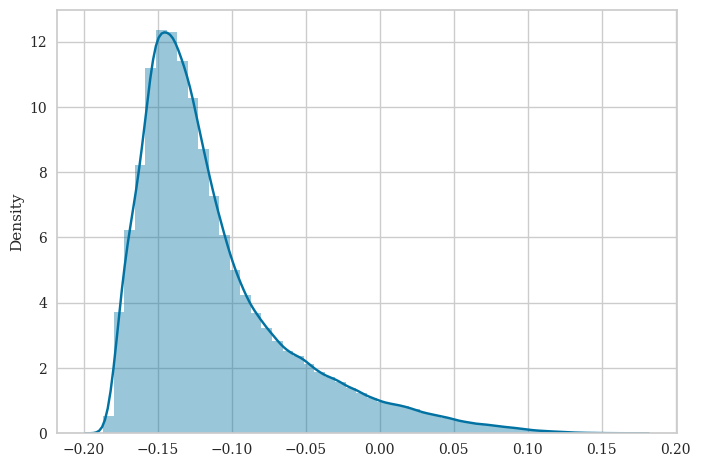

In [10]:
plt.rcParams['font.family'] = 'DeJavu Serif'
sns.distplot(data_ano[['Anomaly_Score']])

In [11]:
data_ano

,분류,거래량,미결제약정,simple moneyness,잔존만기,rate,kvix,종가,Anomaly,Anomaly_Score
0,1,3,38,0.853653,0.464286,1.964,19.740000,42.434170,0,-0.125811
1,1,1,1090,0.826336,0.126984,1.964,19.740000,53.501606,0,-0.133333
2,1,7,549,0.800713,0.206349,1.964,19.740000,62.985649,0,-0.137642
3,1,3,3,0.882838,0.285714,1.964,19.740000,33.313255,0,-0.143178
4,1,924,2273,0.860767,0.126984,1.964,19.740000,41.042740,0,-0.128051
...,...,...,...,...,...,...,...,...,...,...
346670,1,5882,4406,0.900604,0.043651,3.594,17.780001,38.936886,0,-0.086652
346671,0,18624,20649,1.084818,0.043651,3.594,17.780001,0.150000,0,-0.053641
346672,1,3640,2521,0.883926,0.043651,3.594,17.780001,46.405128,0,-0.085688
346673,1,22122,7772,0.935922,0.043651,3.594,17.780001,24.230400,0,-0.063774


In [12]:
x = data_ano.drop(['종가'],axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]; x_train = x_train.drop(['Anomaly','Anomaly_Score'],axis=1)
as_val = x_val[['Anomaly_Score']]; x_val = x_val.drop(['Anomaly','Anomaly_Score'],axis=1)
as_test = x_test[['Anomaly_Score']]; x_test = x_test.drop(['Anomaly','Anomaly_Score'],axis=1)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

(221872, 7) (55468, 7) (69335, 7) (221872, 1) (55468, 1) (69335, 1) (221872, 1) (55468, 1) (69335, 1)


In [13]:
y_test.describe()

,종가
count,69335.000000
mean,20.491476
std,31.496487
min,0.000000
25%,0.480000
50%,4.700000
75%,30.422901
max,235.826584


## Option type classification
## moneyness
- ITM  moneyness < 0.95
- ATM  0.95< moneyness <1.05
- OTM  1.05< moneyness  

In [15]:
data_ano1 = data_ano.copy()
data_ano1['classify'] = data_ano1.apply(option_type, axis=1)
data_ano1['mn_class'] = data_ano1['classify'].apply(simple_classify)
class_mapping = {'ITM': 0, 'OTM': 1, 'ATM': 2}
data_ano1['mn_class'] = data_ano1['mn_class'].map(class_mapping)

In [16]:
x_test['mn_class'] = data_ano1['mn_class'].loc[x_test.index]

In [17]:
itm_data = x_test[x_test['mn_class'] == 0]; itm_data = itm_data.drop(['mn_class'], axis=1)
otm_data = x_test[x_test['mn_class'] == 1]; otm_data = otm_data.drop(['mn_class'], axis=1)
atm_data = x_test[x_test['mn_class'] == 2]; atm_data = atm_data.drop(['mn_class'], axis=1)

itm_y = y_test.loc[itm_data.index]
otm_y = y_test.loc[otm_data.index]
atm_y = y_test.loc[atm_data.index]
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (itm_data.shape[0] / x_test.shape[0]) * 100
per2 = (otm_data.shape[0] /  x_test.shape[0]) * 100
per3 = (atm_data.shape[0] /  x_test.shape[0]) * 100
print(f"itm {per1:.4f}% , otm {per2:.4f}%, atm {per3:.4f}%" )

itm_dataloader = create_dataloader(itm_data, itm_y)
otm_dataloader = create_dataloader(otm_data, otm_y)
atm_dataloader = create_dataloader(atm_data, atm_y)

(22442, 7) (32652, 7) (14241, 7)
itm 32.3675% , otm 47.0931%, atm 20.5394%


In [18]:
x_test = x_test.drop(['mn_class'], axis=1)
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

(221872, 7) (55468, 7) (69335, 7) (221872, 1) (55468, 1) (69335, 1) (221872, 1) (55468, 1) (69335, 1)


In [19]:
x_train = torch.from_numpy(x_train.values).float()
x_val = torch.from_numpy(x_val.values).float()
x_test = torch.from_numpy(x_test.values).float()
y_train = torch.from_numpy(y_train.values).float()
y_val = torch.from_numpy(y_val.values).float()
y_test = torch.from_numpy(y_test.values).float()
as_train = torch.from_numpy(as_train.values).float()
as_val = torch.from_numpy(as_val.values).float()
as_test = torch.from_numpy(as_test.values).float()

dataset_train = torch.utils.data.TensorDataset(x_train, y_train, as_train)
dataset_val = torch.utils.data.TensorDataset(x_val, y_val, as_val)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test, as_test)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=500, shuffle=False, num_workers=8, drop_last=True)

In [20]:
test_dataloaders = [itm_dataloader, otm_dataloader, atm_dataloader]

## Market Frequet classification
## Volume 
- very low [0, 10]
- low [10, 100]
- high [100, 1000]
- very high [1000, float('inf')]

In [21]:
x = data_ano.drop(['종가'],axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]; x_train = x_train.drop(['Anomaly','Anomaly_Score'],axis=1)
as_val = x_val[['Anomaly_Score']]; x_val = x_val.drop(['Anomaly','Anomaly_Score'],axis=1)
as_test = x_test[['Anomaly_Score']]; x_test = x_test.drop(['Anomaly','Anomaly_Score'],axis=1)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

(221872, 7) (55468, 7) (69335, 7) (221872, 1) (55468, 1) (69335, 1) (221872, 1) (55468, 1) (69335, 1)


In [22]:
data_ano2 = data_ano.copy()
bins = [0, 10, 100, 1000, float('inf')]  # 구간 경계값
labels = ['Very Low', 'Low', 'High', 'Very High']
data_ano2['거래량_분류'] = pd.cut(data_ano2['거래량'], bins=bins, labels=labels, right=False)
class_mapping = {'Very High': 0, 'High': 1, 'Low': 2, 'Very Low': 3}
data_ano2['freq'] = data_ano2['거래량_분류'].map(class_mapping)
data_ano2 = data_ano2.drop(['거래량_분류'], axis=1)

print(data_ano2[['freq']].sample(10))

       freq
312257    3
162608    2
140660    1
227408    2
21732     2
314833    3
278881    2
306786    0
231393    2
136722    2


In [23]:
x_test['freq'] = data_ano2['freq'].loc[x_test.index]

In [24]:
y_test.describe()

,종가
count,69335.000000
mean,20.491476
std,31.496487
min,0.000000
25%,0.480000
50%,4.700000
75%,30.422901
max,235.826584


In [25]:
vhf_data = x_test[x_test['freq'] == 0]; vhf_data = vhf_data.drop(['freq'], axis=1)
hf_data = x_test[x_test['freq'] == 1]; hf_data = hf_data.drop(['freq'], axis=1)
lf_data = x_test[x_test['freq'] == 2]; lf_data = lf_data.drop(['freq'], axis=1)
vlf_data = x_test[x_test['freq'] == 3]; vlf_data = vlf_data.drop(['freq'], axis=1)

vhf_y = y_test.loc[vhf_data.index]
hf_y = y_test.loc[hf_data.index]
lf_y = y_test.loc[lf_data.index]
vlf_y = y_test.loc[vlf_data.index]
print(itm_data.shape, otm_data.shape, atm_data.shape)

per1 = (vhf_data.shape[0] / x_test.shape[0]) * 100
per2 = (hf_data.shape[0] /  x_test.shape[0]) * 100
per3 = (lf_data.shape[0] /  x_test.shape[0]) * 100
per4 = (vlf_data.shape[0] /  x_test.shape[0]) * 100
print(f"VeryHighFreq {per1:.4f}% , HighFreq {per2:.4f}%, LowFreq {per3:.4f}% ,VeryLowFreq {per4:.4f}%")

vhf_dataloader = create_dataloader(vhf_data, vhf_y)
hf_dataloader = create_dataloader(hf_data, hf_y)
lf_dataloader = create_dataloader(lf_data, lf_y)
vlf_dataloader = create_dataloader(vlf_data, vlf_y)

(22442, 7) (32652, 7) (14241, 7)
VeryHighFreq 20.3519% , HighFreq 20.6216%, LowFreq 25.7720% ,VeryLowFreq 33.2545%


In [26]:
x_test = x_test.drop(['freq'], axis=1)
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

(221872, 7) (55468, 7) (69335, 7) (221872, 1) (55468, 1) (69335, 1) (221872, 1) (55468, 1) (69335, 1)


In [27]:
x_train = torch.from_numpy(x_train.values).float()
x_val = torch.from_numpy(x_val.values).float()
x_test = torch.from_numpy(x_test.values).float()
y_train = torch.from_numpy(y_train.values).float()
y_val = torch.from_numpy(y_val.values).float()
y_test = torch.from_numpy(y_test.values).float()
as_train = torch.from_numpy(as_train.values).float()
as_val = torch.from_numpy(as_val.values).float()
as_test = torch.from_numpy(as_test.values).float()

dataset_train = torch.utils.data.TensorDataset(x_train, y_train, as_train)
dataset_val = torch.utils.data.TensorDataset(x_val, y_val, as_val)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test, as_test)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=500, shuffle=False, num_workers=8, drop_last=True)
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

torch.Size([221872, 7]) torch.Size([55468, 7]) torch.Size([69335, 7]) torch.Size([221872, 1]) torch.Size([55468, 1]) torch.Size([69335, 1]) torch.Size([221872, 1]) torch.Size([55468, 1]) torch.Size([69335, 1])


## maturity classification
- 잔존만기 = 0.04365 >> [2019.1.31 ~ 2019.2.14] >> biweek
- 잔존만기 = 0.09127 >> [2019.1.15 ~ 2019.2.14] >> month
- 잔존만기 = 0.25794 >> [2019.1.11 ~ 2019.4.11] >> quart
- 잔존만기 = 0.52778 >> [2019.3.12 ~ 2019.9.12] >> half
- 잔존만기 = 0.99603 >> [2019.3.28 ~ 2020.3.12] >> year

In [28]:
x = data_ano.drop(['종가'],axis=1)
y = data_ano[['종가']]

x['rate'] *= 0.01
x['kvix'] *= 0.01

scaler = MinMaxScaler()
scaler.fit(x[['거래량','미결제약정']])
x[['거래량','미결제약정']] = scaler.transform(x[['거래량','미결제약정']])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=0)

as_train = x_train[['Anomaly_Score']]; x_train = x_train.drop(['Anomaly','Anomaly_Score'],axis=1)
as_val = x_val[['Anomaly_Score']]; x_val = x_val.drop(['Anomaly','Anomaly_Score'],axis=1)
as_test = x_test[['Anomaly_Score']]; x_test = x_test.drop(['Anomaly','Anomaly_Score'],axis=1)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

(221872, 7) (55468, 7) (69335, 7) (221872, 1) (55468, 1) (69335, 1) (221872, 1) (55468, 1) (69335, 1)


In [29]:
def classify_expiry(row):
    if row < 0.04165:
        return 'biweek'
    elif 0.04165 <= row < 0.0825: #0.0833
        return 'onemonth'
    elif 0.0825 <= row < 0.25:
        return 'quarter'
    elif 0.25 <= row < 0.5:
        return 'half'
    else: 
        return 'year'

In [30]:
data_ano3 = data_ano.copy()
data_ano3['잔존만기_분류'] = data_ano3['잔존만기'].apply(classify_expiry)

class_mapping = {'biweek': 0, 'onemonth': 1, 'quarter': 2, 'half': 3, 'year': 4}
data_ano3['expiry'] = data_ano3['잔존만기_분류'].map(class_mapping)

# 불필요한 컬럼 제거
data_ano3 = data_ano3.drop(['잔존만기_분류'], axis=1)
print(data_ano3[['expiry']].sample(10))

        expiry
133361       2
327277       3
271104       2
230052       2
143784       2
10182        4
48795        1
282493       2
38382        2
295648       2


In [31]:
x_test['expiry'] = data_ano3['expiry'].loc[x_test.index]

In [32]:
b_data = x_test[x_test['expiry'] == 0]; b_data = b_data.drop(['expiry'], axis=1)
o_data = x_test[x_test['expiry'] == 1]; o_data = o_data.drop(['expiry'], axis=1)
q_data = x_test[x_test['expiry'] == 2]; q_data = q_data.drop(['expiry'], axis=1)
h_data = x_test[x_test['expiry'] == 3]; h_data = h_data.drop(['expiry'], axis=1)
y_data = x_test[x_test['expiry'] == 4]; y_data = y_data.drop(['expiry'], axis=1)

b_y = y_test.loc[b_data.index]
o_y = y_test.loc[o_data.index]
q_y = y_test.loc[q_data.index]
h_y = y_test.loc[h_data.index]
y_y = y_test.loc[y_data.index]
print(b_data.shape, o_data.shape, q_data.shape, h_data.shape, y_data.shape)

per1 = (b_data.shape[0] / x_test.shape[0]) * 100
per2 = (o_data.shape[0] /  x_test.shape[0]) * 100
per3 = (q_data.shape[0] /  x_test.shape[0]) * 100
per4 = (h_data.shape[0] /  x_test.shape[0]) * 100
per5 = (y_data.shape[0] /  x_test.shape[0]) * 100
print(f"Bi week {per1:.4f}% , OneMonth {per2:.4f}%, Quarter {per3:.4f}% , Half {per4:.4f}%, Year {per5:.4f}%")

b_dataloader = create_dataloader(b_data, b_y)
o_dataloader = create_dataloader(o_data, o_y)
q_dataloader = create_dataloader(q_data, q_y)
h_dataloader = create_dataloader(h_data, h_y)
y_dataloader = create_dataloader(y_data, y_y)

(2003, 7) (9914, 7) (35280, 7) (14923, 7) (7215, 7)
Bi week 2.8889% , OneMonth 14.2987%, Quarter 50.8834% , Half 21.5230%, Year 10.4060%


In [33]:
y_test.describe()

,종가
count,69335.000000
mean,20.491476
std,31.496487
min,0.000000
25%,0.480000
50%,4.700000
75%,30.422901
max,235.826584


In [34]:
print("y_test range:", y_test.min().item(), "~", y_test.max().item())

y_test range: 0.0 ~ 235.8265838623047


In [35]:
x_test = x_test.drop(['expiry'], axis=1)
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

(221872, 7) (55468, 7) (69335, 7) (221872, 1) (55468, 1) (69335, 1) (221872, 1) (55468, 1) (69335, 1)


In [36]:
x_train = torch.from_numpy(x_train.values).float()
x_val = torch.from_numpy(x_val.values).float()
x_test = torch.from_numpy(x_test.values).float()
y_train = torch.from_numpy(y_train.values).float()
y_val = torch.from_numpy(y_val.values).float()
y_test = torch.from_numpy(y_test.values).float()
as_train = torch.from_numpy(as_train.values).float()
as_val = torch.from_numpy(as_val.values).float()
as_test = torch.from_numpy(as_test.values).float()

dataset_train = torch.utils.data.TensorDataset(x_train, y_train, as_train)
dataset_val = torch.utils.data.TensorDataset(x_val, y_val, as_val)
dataset_test = torch.utils.data.TensorDataset(x_test, y_test, as_test)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=500, shuffle=True, num_workers=8, drop_last=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=500, shuffle=False, num_workers=8, drop_last=True)
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape , as_train.shape, as_val.shape, as_test.shape)

torch.Size([221872, 7]) torch.Size([55468, 7]) torch.Size([69335, 7]) torch.Size([221872, 1]) torch.Size([55468, 1]) torch.Size([69335, 1]) torch.Size([221872, 1]) torch.Size([55468, 1]) torch.Size([69335, 1])


In [37]:
# Placeholder lists for all models and MSE values
basic_models = []
ano_models = []
mse_values_k0_list = []
mse_values_k7_list = []

In [38]:
test_dataloader_options = {
    'option_type': [itm_dataloader, otm_dataloader, atm_dataloader],
    'freq': [vhf_dataloader, hf_dataloader, lf_dataloader, vlf_dataloader],
    'maturity': [b_dataloader, o_dataloader, q_dataloader, h_dataloader, y_dataloader]
}

In [39]:
# Train the basic model with k=0.0
model = NN(x_train.shape[1]).to(rank)
basic_model, loss_list_k0 = train_model(model, 200, dataloader_train, dataloader_val, 0.0, rank)
basic_models.append(basic_model)


# Train the ano model with k=0.7
model = NN(x_train.shape[1]).to(rank)
ano_model, loss_list_k7 = train_model(model, 200, dataloader_train, dataloader_val, 0.7, rank)
ano_models.append(ano_model)

# Evaluate the models on each test dataloader option and store the MSE values
for key, test_dataloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(basic_model, dataloader_test, test_dataloaders, rank)
    mse_values_k7 = evaluate_model(ano_model, dataloader_test, test_dataloaders, rank)

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model {1} ({key}):", mse_values_k0)
    print(f"MSE values for ano model {1} ({key}):", mse_values_k7)

 88%|████████▊ | 177/200 [17:46<02:18,  6.02s/it]

Early stopping at epoch 177 for basic model (k=0.0)



[DEBUG] 첫 배치 예측값: [3.9581656e-02 1.2949693e+02 1.0575948e+02 7.7006221e-02 3.7585938e+01
 2.4565735e+00 2.9194260e+01 4.2254782e+00 7.3176265e-02 6.4956269e+00]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]

[DEBUG] 첫 배치 예측값: [  0.7736112 126.77206   101.92305     1.425981   37.81764     2.5083394
  29.654251    4.2027683   0.6313677   6.2394023]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]
MSE values for basic model 1 (option_type): [5.744556863828375, 15.826485848203435, 0.3596172937115854, 2.144484313310323]
MSE values for ano model 1 (option_type): [5.269825240152432, 14.331441368287653, 0.39262235861631434, 2.132046599017568]

[DEBUG] 첫 배치 예측값: [3.9581656e-02 1.2949693e+02 1.0575948e+02 7.7006221e-02 3.7585938e+01
 2.4565735e+00 2.9194260e+01 4.2254782e+00 7.3176265e-02 6.4956269e+00]
[DEBUG] 첫 배치 실제값: [  0.25     125.1

In [40]:
# Train the basic model with k=0.0
model = NN(x_train.shape[1]).to(rank)
basic_model, loss_list_k0 = train_model(model, 200, dataloader_train, dataloader_val, 0.0, rank)
basic_models.append(basic_model)


# Train the ano model with k=0.7
model = NN(x_train.shape[1]).to(rank)
ano_model, loss_list_k7 = train_model(model, 200, dataloader_train, dataloader_val, 0.7, rank)
ano_models.append(ano_model)

# Evaluate the models on each test dataloader option and store the MSE values
for key, test_dataloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(basic_model, dataloader_test, test_dataloaders, rank)
    mse_values_k7 = evaluate_model(ano_model, dataloader_test, test_dataloaders, rank)

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model {2} ({key}):", mse_values_k0)
    print(f"MSE values for ano model {2} ({key}):", mse_values_k7)

 86%|████████▌ | 171/200 [15:38<02:39,  5.49s/it]

Early stopping at epoch 171 for basic model (k=0.0)



[DEBUG] 첫 배치 예측값: [  0.14841753 127.041595   101.51674      0.6053731   36.84913
   2.4586275   29.477446     3.9767687    0.21625021   6.1032443 ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]

[DEBUG] 첫 배치 예측값: [  0.3473837  125.22688    100.336        0.6125165   36.21954
   2.4182363   29.412067     4.4161425    0.20317057   6.442015  ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]
MSE values for basic model 2 (option_type): [4.975586076605305, 13.530760860322795, 0.31650811841504445, 2.13177808911244]
MSE values for ano model 2 (option_type): [5.735198652289638, 15.797046164339951, 0.32200299620724915, 2.2474372535507707]

[DEBUG] 첫 배치 예측값: [  0.14841753 127.041595   101.51674      0.6053731   36.84913
   2.4586275   29.477446     3.9767687    0.21625021   6.1032443 ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333   

In [41]:
# Train the basic model with k=0.0
model = NN(x_train.shape[1]).to(rank)
basic_model, loss_list_k0 = train_model(model, 200, dataloader_train, dataloader_val, 0.0, rank)
basic_models.append(basic_model)


# Train the ano model with k=0.7
model = NN(x_train.shape[1]).to(rank)
ano_model, loss_list_k7 = train_model(model, 200, dataloader_train, dataloader_val, 0.7, rank)
ano_models.append(ano_model)

# Evaluate the models on each test dataloader option and store the MSE values
for key, test_dataloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(basic_model, dataloader_test, test_dataloaders, rank)
    mse_values_k7 = evaluate_model(ano_model, dataloader_test, test_dataloaders, rank)

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model {3} ({key}):", mse_values_k0)
    print(f"MSE values for ano model {3} ({key}):", mse_values_k7)

 98%|█████████▊| 196/200 [18:26<00:22,  5.65s/it]

Early stopping at epoch 196 for basic model (k=0.0)



[DEBUG] 첫 배치 예측값: [  0.23637113 125.90534    103.613045     1.0867343   38.199047
   2.929444    31.806938     4.217372     0.31234762   6.723856  ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]

[DEBUG] 첫 배치 예측값: [  0.4595893  125.02148    102.38023      1.3719962   37.71033
   2.515442    30.582968     4.629854     0.42917198   6.0632806 ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]
MSE values for basic model 3 (option_type): [5.305489763446581, 14.441053761222427, 0.33138213167316216, 2.2651759034171683]
MSE values for ano model 3 (option_type): [5.522330650227845, 15.164569552528736, 0.3419836813537424, 2.1506500158768653]

[DEBUG] 첫 배치 예측값: [  0.23637113 125.90534    103.613045     1.0867343   38.199047
   2.929444    31.806938     4.217372     0.31234762   6.723856  ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333

In [42]:
# Train the basic model with k=0.0
model = NN(x_train.shape[1]).to(rank)
basic_model, loss_list_k0 = train_model(model, 200, dataloader_train, dataloader_val, 0.0, rank)
basic_models.append(basic_model)


# Train the ano model with k=0.7
model = NN(x_train.shape[1]).to(rank)
ano_model, loss_list_k7 = train_model(model, 200, dataloader_train, dataloader_val, 0.7, rank)
ano_models.append(ano_model)

# Evaluate the models on each test dataloader option and store the MSE values
for key, test_dataloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(basic_model, dataloader_test, test_dataloaders, rank)
    mse_values_k7 = evaluate_model(ano_model, dataloader_test, test_dataloaders, rank)

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model {4} ({key}):", mse_values_k0)
    print(f"MSE values for ano model {4} ({key}):", mse_values_k7)

 95%|█████████▌| 190/200 [18:04<00:57,  5.71s/it]


Early stopping at epoch 190 for basic model (k=0.0)


 90%|█████████ | 180/200 [15:49<01:45,  5.28s/it]

Early stopping at epoch 180 for basic model (k=0.0)



[DEBUG] 첫 배치 예측값: [  0.54187447 127.13605     98.54242      0.9086721   35.781483
   2.6233869   26.651798     3.9572012    0.2117834    6.566131  ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]

[DEBUG] 첫 배치 예측값: [  0.19228995 127.455605   101.75707      0.58416474  38.178207
   2.5030336   29.442867     4.1815033    0.12823164   6.205842  ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]
MSE values for basic model 4 (option_type): [6.3109386017729365, 17.4670124773716, 0.3405529825323542, 2.3741547902173634]
MSE values for ano model 4 (option_type): [5.154699864056643, 14.08873065347812, 0.33599369233779114, 2.0759484122829623]

[DEBUG] 첫 배치 예측값: [  0.54187447 127.13605     98.54242      0.9086721   35.781483
   2.6233869   26.651798     3.9572012    0.2117834    6.566131  ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333 

In [43]:
# Train the basic model with k=0.0
model = NN(x_train.shape[1]).to(rank)
basic_model, loss_list_k0 = train_model(model, 200, dataloader_train, dataloader_val, 0.0, rank)
basic_models.append(basic_model)


# Train the ano model with k=0.7
model = NN(x_train.shape[1]).to(rank)
ano_model, loss_list_k7 = train_model(model, 200, dataloader_train, dataloader_val, 0.7, rank)
ano_models.append(ano_model)

# Evaluate the models on each test dataloader option and store the MSE values
for key, test_dataloaders in test_dataloader_options.items():
    mse_values_k0 = evaluate_model(basic_model, dataloader_test, test_dataloaders, rank)
    mse_values_k7 = evaluate_model(ano_model, dataloader_test, test_dataloaders, rank)

    mse_values_k0_list.append((key, mse_values_k0))
    mse_values_k7_list.append((key, mse_values_k7))
    print(f"MSE values for basic model {5} ({key}):", mse_values_k0)
    print(f"MSE values for ano model {5} ({key}):", mse_values_k7)

 90%|████████▉ | 179/200 [15:41<01:50,  5.26s/it]


Early stopping at epoch 179 for basic model (k=0.0)


 96%|█████████▌| 191/200 [16:29<00:46,  5.18s/it]

Early stopping at epoch 191 for basic model (k=0.0)



[DEBUG] 첫 배치 예측값: [  0.46605662 126.61548    104.72948      0.7230353   36.6202
   2.9337382   28.93395      4.1990185    0.23983133   6.2289176 ]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]

[DEBUG] 첫 배치 예측값: [ 1.2435335e-01  1.2800470e+02  1.0170395e+02  2.4306864e-01
  3.6897526e+01  2.2990508e+00  2.9903425e+01  3.8914962e+00
 -8.0861628e-02  6.2771702e+00]
[DEBUG] 첫 배치 실제값: [  0.25     125.11711   97.66333    0.63      36.896866   2.63
  33.642292   4.7        0.2        6.15    ]
MSE values for basic model 5 (option_type): [5.444863014422097, 14.957708470035858, 0.3242550168396118, 2.141607303148186]
MSE values for ano model 5 (option_type): [5.256710136040219, 14.438468175212135, 0.3380496154408076, 2.0164914559728535]

[DEBUG] 첫 배치 예측값: [  0.46605662 126.61548    104.72948      0.7230353   36.6202
   2.9337382   28.93395      4.1990185    0.23983133   6.2289176 ]
[DEBUG] 첫 배치 실제값: [  0.25     12

In [44]:
# 추가된 MSE 값을 별도의 딕셔너리에 저장
mse_values_k0_dict = {key: mse for key, mse in mse_values_k0_list}
mse_values_k7_dict = {key: mse for key, mse in mse_values_k7_list}

# 각 세션에 대해 MSE 비교를 위한 플롯 생성
labels_options = {
    'option_type': ['Total', 'ITM', 'OTM', 'ATM'],
    'freq': ['Total', 'Very High', 'High', 'Low', 'Very Low'],
    'maturity': ['Total', 'Biweek', 'OneMonth', 'Quarter', 'Half', 'Year']
}

for i in range(5):
    for key, labels in labels_options.items():
        mse_k0 = mse_values_k0_dict.get(key, None)
        mse_k7 = mse_values_k7_dict.get(key, None)
        if mse_k0 and mse_k7:
            plot_mse_comparison(mse_k0[i], mse_k7[i], labels)


TypeError: object of type 'numpy.float64' has no len()

In [ ]:
mse_values_k0_1 = mse_values_k0_list[0:3]
mse_values_k0_2 = mse_values_k0_list[3:6]
mse_values_k0_3 = mse_values_k0_list[6:9]
mse_values_k0_4 = mse_values_k0_list[9:12]
mse_values_k0_5 = mse_values_k0_list[12:15]

mse_values_k7_1 = mse_values_k7_list[0:3]
mse_values_k7_2 = mse_values_k7_list[3:6]
mse_values_k7_3 = mse_values_k7_list[6:9]
mse_values_k7_4 = mse_values_k7_list[9:12]
mse_values_k7_5 = mse_values_k7_list[12:15]

In [ ]:
for i in range(5):
    for key, labels in labels_options.items():
        mse_k0 = mse_values_k0_list[3*i:3*(i+1)]
        mse_k7 = mse_values_k7_list[3*i:3*(i+1)]
        for j, (k0, k7) in enumerate(zip(mse_k0, mse_k7)):
            if k0[0] == key:
                plot_mse_comparison(k0[1], k7[1], labels)